Nome: Felipe Faustino Brito

Matrícula: 2021007366

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import control as ctl
import control.matlab as cnt
pi = np.pi

### 1) Gerar o sinal no Python com duração de 2s. Este sinal será usado para testar o filtro a ser desenvolvido.

In [8]:
def get_signal(components: dict[float, float], frequency: float, time=None) -> tuple[np.ndarray, np.ndarray]:
    """
        Gera um sinal composto por várias componentes senoidais.
        
        Params:
            components (dict[float, float]): Um dicionário onde as chaves são as frequências (em Hz) e os valores são as amplitudes das componentes senoidais.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            time (np.ndarray, opcional): Um array de tempos. Se não for fornecido, será gerado automaticamente com base na frequência de amostragem.
        Returns:
            tuple[np.ndarray, np.ndarray]: Uma tupla contendo o sinal gerado e o array de tempos.
    """

    if time is None:
        time = np.arange(0, 2, 1/frequency)
    signal_data = np.zeros_like(time)
    for freq, amp in components.items():
        signal_data += amp * np.sin(2 * np.pi * freq * time)

    return signal_data, time

In [7]:
def plot_signal(signal: np.ndarray, time: np.ndarray, frequency: float, limite=800):
    """
        Plota um sinal no domínio do tempo e sua resposta em frequência.
        
        Params:
            signal (np.ndarray): O sinal a ser plotado.
            time (np.ndarray): O array de tempos correspondente ao sinal.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            limite (float, opcional): O limite superior do eixo x da resposta em frequência.
    """
    # Plotar o sinal no domínio do tempo
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title('Sinal composto')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Resposta em frequência (FFT)
    frequencia_fft = np.fft.fftfreq(len(signal), 1/frequency)
    espectro_fft = np.fft.fft(signal)

    # Plotar a magnitude da resposta em frequência
    plt.figure(figsize=(10, 4))
    plt.plot(frequencia_fft[:len(frequencia_fft)//2], np.abs(espectro_fft)[:len(espectro_fft)//2])
    plt.title('Resposta em frequência do sinal')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, limite)
    plt.show()

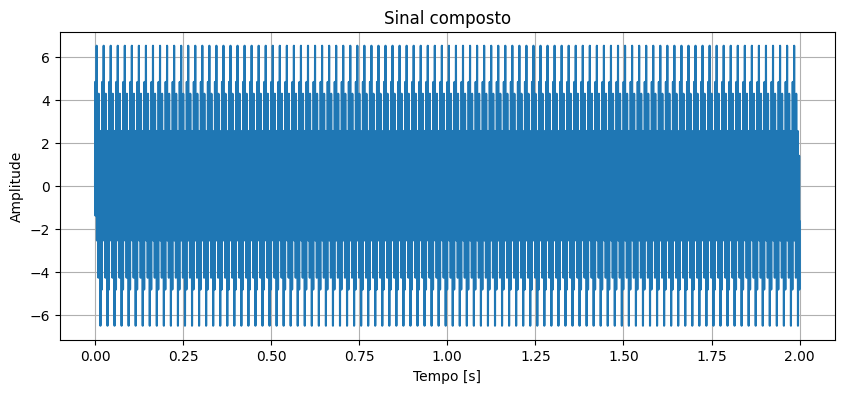

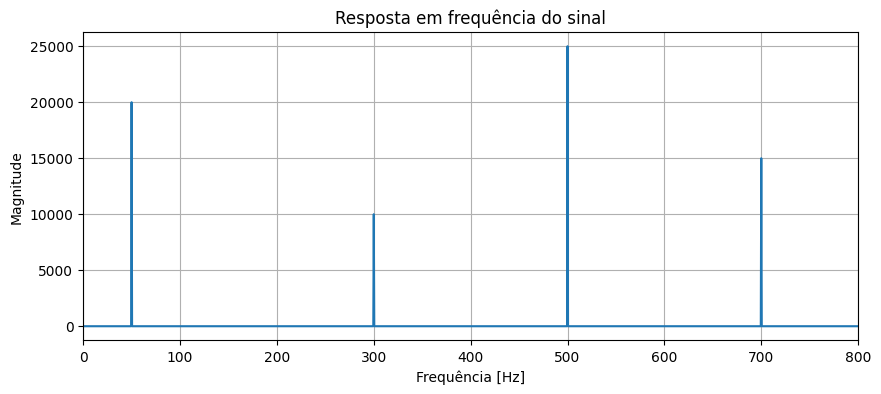

In [9]:
fs = 10000

components = {
    50: 2,   # 50Hz com amplitude 2
    300: 1,  # 300Hz com amplitude 1
    500: 2.5, # 500Hz com amplitude 2.5
    700: 1.5 # 700Hz com amplitude 1.5
}

signal_data, time = get_signal(components=components, frequency=fs)

plot_signal(signal=signal_data, time=time, frequency=fs)

### 2) Projetar um filtro IIR Butterworth (manualmente, usando as equações do filtro) para eliminar todas as componentes (reduzir para menos de 20% de sua amplitude original), exceto a de 300Hz. É desejável que o filtro não afete (tolerância de ±5%) as amplitudes das componentes que devem permanecer no sinal.

In [34]:
def get_Hs_filter(Wp: float, Ws: float, Rp: float, Rs: float, filter_type: str = 'passa-baixa'):
    """
    Calcula a função de transferência em tempo contínuo de um filtro Butterworth passa-alta ou passa-baixa.
    
    Params:
        Wp (float): Frequência de corte na faixa de passagem (em rad/s).
        Ws (float): Frequência de corte na faixa de rejeição (em rad/s).
        Rp (float): Ripple na faixa de passagem (em dB).
        Rs (float): Ripple na faixa de rejeição (em dB).
        filter_type (str): Tipo de filtro (passa-baixa ou passa-alta).
    Returns:
        Hs (control.TransferFunction): Função de transferência em tempo contínuo do filtro.
    """

    # 2) Cálculo da Ordem do Filtro e sua Frequência de Corte:
    #calcular a frequência de corte com a ordem negativa
    N = np.log10((1/Rp**2 - 1)/(1/Rs**2 - 1)) / (2*np.log10(Wp/Ws))
    # print('\n', N)
    N = int(np.sign(N)*np.ceil(abs(N)))
    # print('\nN = ', N)
    Wc = Wp*(1/(1/Rp**2 - 1))**(1/(2*N))
    print('Wc = ',Wc,'rad/s')
    print('fc = ',Wc/(2*pi),'Hz')

    # 3) Cálculo dos polos do filtro:
    # para o restante do procedimento, usar a ordem com sinal positivo.
    if N<0:
        N = -N
    print('\nN = ',N)
    k = np.arange(0,2*N)
    polos = Wc*np.exp((1j*pi/(2*N))*(2*k+N-1))
    # print('\nTodos os polos: ',polos)
    polosEst = [p for p in polos if np.real(p)<0]
    # print('Polos estáveis: ',polosEst)
    # 4) Montar a função de transferência contínua:
    #no numerador, usa-se s**N no lugar de Wc**N
    if filter_type == 'passa-alta':
        numS = np.append(1,np.zeros(N))
    else:
        numS = Wc**N
    denS = np.poly(polosEst)
    Hs = ctl.tf(numS,denS)
    print('H(s):',Hs)
    return Hs

In [26]:
def get_Hz_filter(Hs: ctl.TransferFunction, frequency: float, method: str = 'bilinear') -> ctl.TransferFunction:
    """
        Converte uma função de transferência em tempo contínuo para tempo discreto.

        Params:
            Hs (control.TransferFunction): Função de transferência em tempo contínuo.
            frequency (float): Frequência de amostragem (em Hz).
            method (str): Método de discretização ('bilinear' ou 'tustin').
        Returns:
            Hz (control.TransferFunction): Função de transferência em tempo discreto.
    """
    Ts = 1/frequency
    Hz = ctl.c2d(Hs,Ts,method)
    print('H(z):',Hz)
    return Hz
    

In [27]:
def plot_Hz(Hz: ctl.TransferFunction, frequency: float):
    numZ = Hz.num[0][0]
    denZ = Hz.den[0][0]
    w,h = signal.freqz(numZ,denZ,worN=1000,fs=frequency)
    fig2 = plt.figure(2)
    fig2.clf()
    ax0 = fig2.add_subplot(211)
    ax0.plot(w,20*np.log10(abs(h)))
    ax0.grid(True)
    ax1 = fig2.add_subplot(212)
    ax1.plot(w,np.angle(h)*180/np.pi)
    ax1.grid(True)
    plt.show()

In [28]:
def plot_transfer_functions(transfer_functions: list[ctl.TransferFunction], legend: list[str]=None):
    """
    Plota o diagrama de Bode de uma ou mais funções de transferência.

    Params:
        transfer_functions (list[control.TransferFunction]): Lista de funções de transferência.
        legend (list[str], opcional): Lista de legendas para as funções de transferência.
    """
    plt.figure(1)
    plt.clf()
    for tf in transfer_functions:
        ctl.bode(tf,dB=True,Hz=True)
    if legend:
        plt.legend(legend)
    plt.show()

In [46]:
# Parametros do Passa-Alta
Wp_1 = 2*pi*250
Ws_1 = 2*pi*100

# Parametros do Passa-Baixa
Wp_2 = 2*pi*350
Ws_2 = 2*pi*450   

# Ripple na faixa de passagem e rejeição
Rp = 0.85
Rs = 0.20


Hs_passa_alta = get_Hs_filter(Wp_1, Ws_1, Rp, Rs, filter_type='passa-alta')

Wc =  1339.236877705083 rad/s
fc =  213.1461690577201 Hz

N =  3
H(s): <TransferFunction>: sys[24]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                  s^3
----------------------------------------
s^3 + 2678 s^2 + 3.587e+06 s + 2.402e+09



In [47]:
Hs_passa_baixa = get_Hs_filter(Wp_2, Ws_2, Rp, Rs, filter_type='passa-baixa')

Wc =  2319.185062588108 rad/s
fc =  369.10976665578403 Hz

N =  9
H(s): <TransferFunction>: sys[25]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                                                                 1.941e+30
--------------------------------------------------------------------------------------------------------------------------------------------
s^9 + 1.336e+04 s^8 + 8.919e+07 s^7 + 3.887e+11 s^6 + 1.215e+15 s^5 + 2.817e+18 s^4 + 4.849e+21 s^3 + 5.984e+24 s^2 + 4.82e+27 s + 1.941e+30



c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part


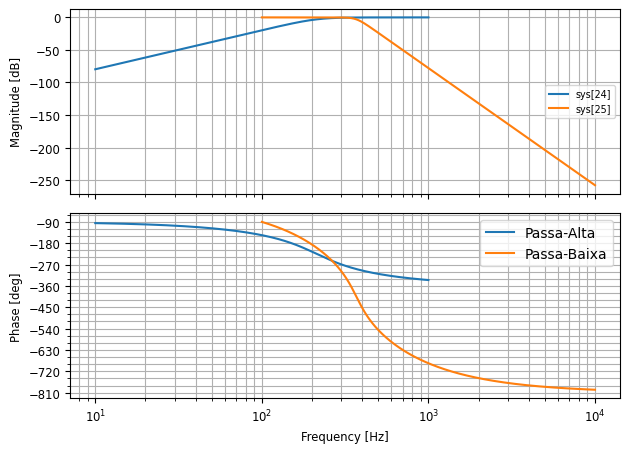

In [48]:
plot_transfer_functions([Hs_passa_alta, Hs_passa_baixa], legend=['Passa-Alta', 'Passa-Baixa'])

c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


0 states have been removed from the model

Passa-faixa:
Hpf(s): <TransferFunction>: sys[29]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                                                                                         1.941e+30 s^3
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
s^12 + 1.603e+04 s^11 + 1.285e+08 s^10 + 6.779e+11 s^9 + 2.608e+15 s^8 + 7.679e+18 s^7 + 1.769e+22 s^6 + 3.199e+25 s^5 + 4.501e+28 s^4 + 4.796e+31 s^3 + 3.686e+34 s^2 + 1.854e+37 s + 4.662e+39



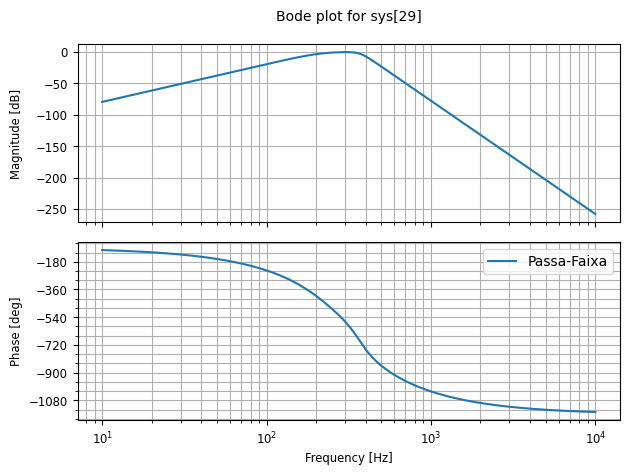

In [49]:
Hs_passa_faixa = ctl.minreal(Hs_passa_baixa * Hs_passa_alta)


print('\nPassa-faixa:')
print('Hpf(s):', Hs_passa_faixa)

plot_transfer_functions([Hs_passa_faixa], legend=['Passa-Faixa'])

c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=4.09771e-71): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=4.09771e-71): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.06525e-71): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


H(z): <TransferFunction>: sys[29]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


1.702e-09 z^12 + 1.021e-08 z^11 + 2.043e-08 z^10 + 3.405e-09 z^9 - 4.597e-08 z^8 - 6.128e-08 z^7 - 2.395e-12 z^6 + 6.129e-08 z^5 + 4.596e-08 z^4 - 3.404e-09 z^3 - 2.043e-08 z^2 - 1.021e-08 z - 1.702e-09
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                z^12 - 10.4 z^11 + 49.7 z^10 - 144.1 z^9 + 282.7 z^8 - 395 z^7 + 403 z^6 - 302.6 z^5 + 166 z^4 - 64.81 z^3 + 17.11 z^2 - 2.742 z + 0.2017

dt = 0.0001



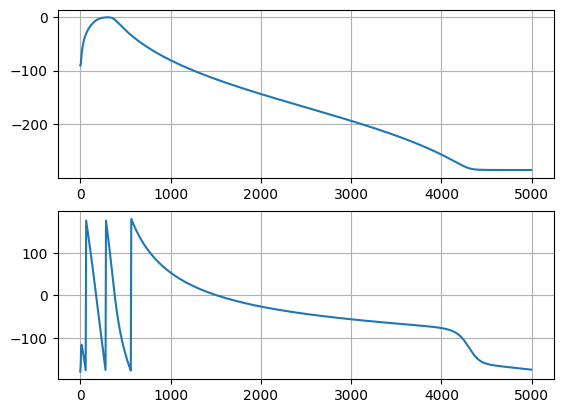

In [50]:
Hz_passa_faixa = get_Hz_filter(Hs_passa_faixa, fs)
plot_Hz(Hz_passa_faixa, fs)

### 3) Fazer uma função Python para implementar o filtro projetado. Esta função deve receber como argumento de entrada somente o sinal a ser filtrado e deve devolver somente o sinal filtrado e não deve conter comandos de construção do filtro. Aplicar esta função no sinal do exercício 1. Forneça o espectro do sinal filtrado que comprova o funcionamento da função de filtragem.

In [51]:
def filtrar_sinal(Hz, signal_data, t):
    """
    Filtra um sinal utilizando a função de transferência discreta Hz.

    Params:
        Hz: Função de transferência discreta do filtro.
        signal_data: Sinal a ser filtrado.

    Returns:
        numpy.ndarray: Sinal filtrado.
    """

    b = np.reshape(Hz.num, -1)
    a = np.reshape(Hz.den, -1)

    yout = signal.lfilter(b, a, signal_data)

    return yout

Sinal filtrado: [0.00000000e+00+0.00000000e+00j 2.82840952e-09+0.00000000e+00j
 5.17051639e-08+1.53088558e-15j ... 8.49682982e-01+1.34079805e-07j
 7.05902591e-01+1.31005289e-07j 5.37215276e-01+1.25861100e-07j]
sinal:  [ 0.          1.66141426  3.11893859 ... -4.19946065 -3.11893859
 -1.66141426]


c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


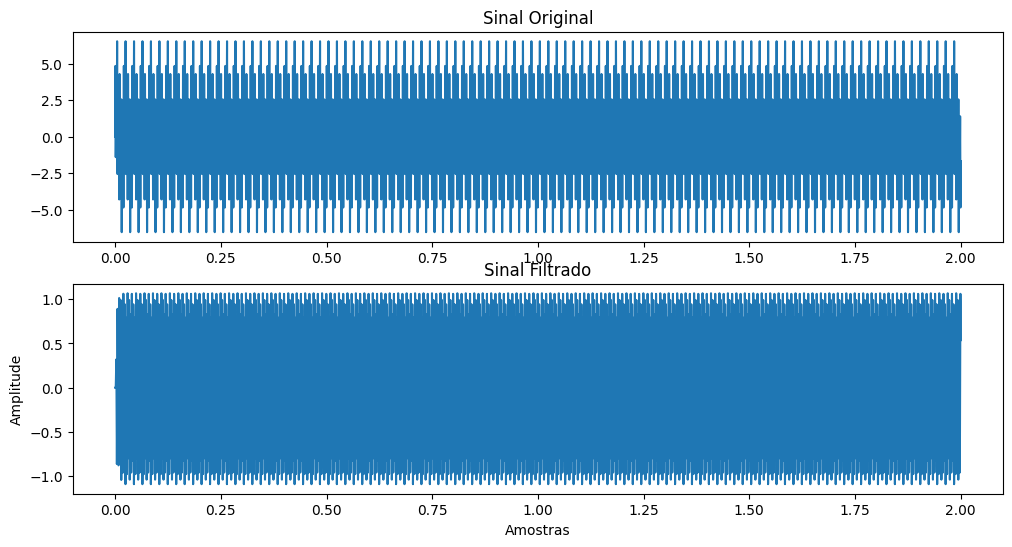

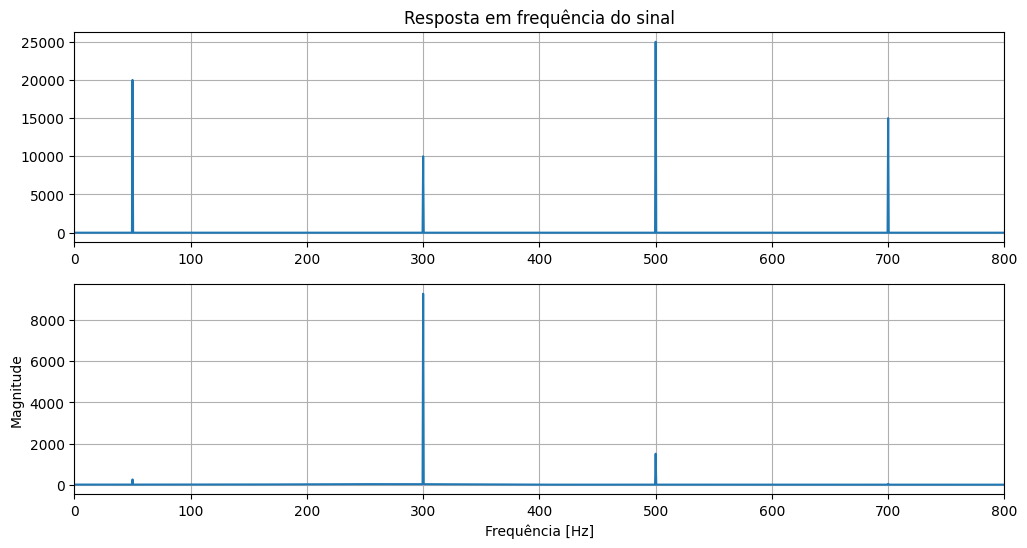

In [52]:
t = np.arange(0, 2, 1/fs)
yout = filtrar_sinal(Hz_passa_faixa, signal_data, t)


print('Sinal filtrado:', yout)
print('sinal: ', signal_data)

# Plot no domínio do tempo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal_data)
plt.title('Sinal Original')
plt.subplot(2, 1, 2)
plt.plot(t, yout)
plt.title('Sinal Filtrado')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')


# Resposta em frequência (FFT)
frequencia = np.fft.fftfreq(len(signal_data), 1/fs)
espectro = np.fft.fft(signal_data)

frequencia_filtr = np.fft.fftfreq(len(yout), 1/fs)
espectro_filtr = np.fft.fft(yout)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencia[:len(frequencia)//2], np.abs(espectro)[:len(frequencia)//2])
plt.title('Resposta em frequência do sinal')
plt.grid(True)
plt.xlim(0, 800)
plt.subplot(2, 1, 2)
plt.plot(frequencia_filtr[:len(frequencia_filtr)//2], np.abs(espectro_filtr)[:len(frequencia_filtr)//2])
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 800)
plt.show()

### 4) Projetar um filtro IIR Butterworth (manualmente, usando as equações do filtro) para eliminar a componente de 500Hz (reduzir para menos de 20% de sua amplitude original). É desejável que o filtro não afete (tolerância de ±5%) as amplitudes das outras componentes que devem permanecer no sinal.

In [59]:
# Parametros do Passa-Alta
Wp_1 = 2*pi*670
Ws_1 = 2*pi*530

# Parametros do Passa-Baixa
Wp_2 = 2*pi*330
Ws_2 = 2*pi*470   

# Ripple na faixa de passagem e rejeição
Rp = 0.85
Rs = 0.25


Hs_passa_alta = get_Hs_filter(Wp_1, Ws_1, Rp, Rs, filter_type='passa-alta')

Wc =  3965.347405919738 rad/s
fc =  631.1046407287507 Hz

N =  8
H(s): <TransferFunction>: sys[40]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                                                             s^8
-----------------------------------------------------------------------------------------------------------------------------
s^8 + 2.033e+04 s^7 + 2.066e+08 s^6 + 1.362e+12 s^5 + 6.351e+15 s^4 + 2.142e+19 s^3 + 5.107e+22 s^2 + 7.902e+25 s + 6.113e+28



In [60]:
Hs_passa_baixa = get_Hs_filter(Wp_2, Ws_2, Rp, Rs, filter_type='passa-baixa')

Wc =  2245.5619816900185 rad/s
fc =  357.3922894051986 Hz

N =  6
H(s): <TransferFunction>: sys[41]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                                       1.282e+20
----------------------------------------------------------------------------------------
s^6 + 8676 s^5 + 3.764e+07 s^4 + 1.035e+11 s^3 + 1.898e+14 s^2 + 2.206e+17 s + 1.282e+20



c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part


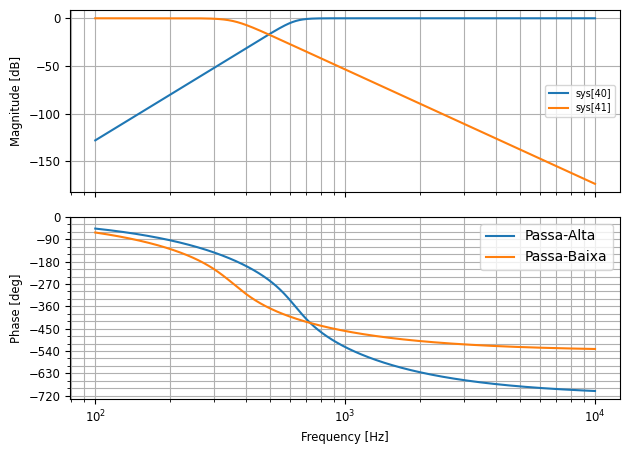

In [63]:
plot_transfer_functions([Hs_passa_alta, Hs_passa_baixa], legend=['Passa-Alta', 'Passa-Baixa'])

c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


0 states have been removed from the model
\Rejeita-faixa:
Hrf(s): <TransferFunction>: sys[48]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


 s^14 + 8676 s^13 + 3.764e+07 s^12 + 1.035e+11 s^11 + 1.898e+14 s^10 + 2.206e+17 s^9 + 2.564e+20 s^8 + 2.606e+24 s^7 + 2.649e+28 s^6 + 1.747e+32 s^5 + 8.144e+35 s^4 + 2.746e+39 s^3 + 6.548e+42 s^2 + 1.013e+46 s + 7.838e+48
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
s^14 + 2.9e+04 s^13 + 4.206e+08 s^12 + 4.023e+12 s^11 + 2.824e+16 s^10 + 1.533e+20 s^9 + 6.608e+23 s^8 + 2.292e+27 s^7 + 6.418e+30 s^6 + 1.443e+34 s^5 + 2.571e+37 s^4 + 3.534e+40 s^3 + 3.558e+43 s^2 + 2.362e+46 s + 7.838e+48



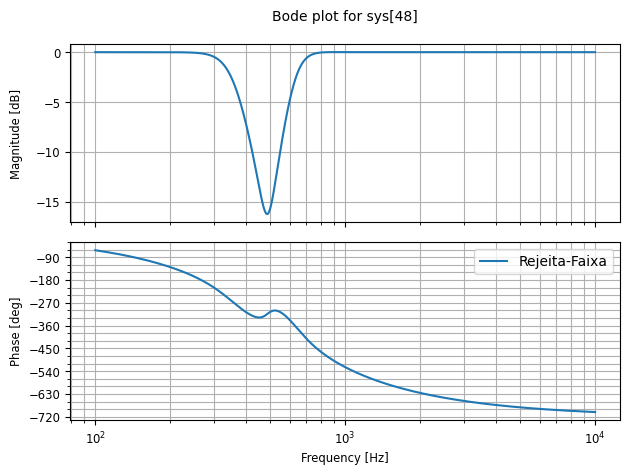

In [64]:
Hs_rejeita_faixa = ctl.minreal(Hs_passa_baixa + Hs_passa_alta)


print('\Rejeita-faixa:')
print('Hrf(s):', Hs_rejeita_faixa)

plot_transfer_functions([Hs_rejeita_faixa], legend=['Rejeita-Faixa'])

c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=2.76133e-89): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=2.76133e-89): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.74474e-89): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


H(z): <TransferFunction>: sys[48]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.3636 z^14 - 4.776 z^13 + 29.14 z^12 - 109.4 z^11 + 282.5 z^10 - 530.8 z^9 + 748 z^8 - 803.4 z^7 + 660.8 z^6 - 414.3 z^5 + 194.8 z^4 - 66.67 z^3 + 15.69 z^2 - 2.273 z + 0.1529
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  z^14 - 11.13 z^13 + 57.76 z^12 - 185.2 z^11 + 409.6 z^10 - 661.4 z^9 + 803.7 z^8 - 746.7 z^7 + 532.8 z^6 - 290.6 z^5 + 119.2 z^4 - 35.69 z^3 + 7.365 z^2 - 0.9378 z + 0.0556

dt = 0.0001



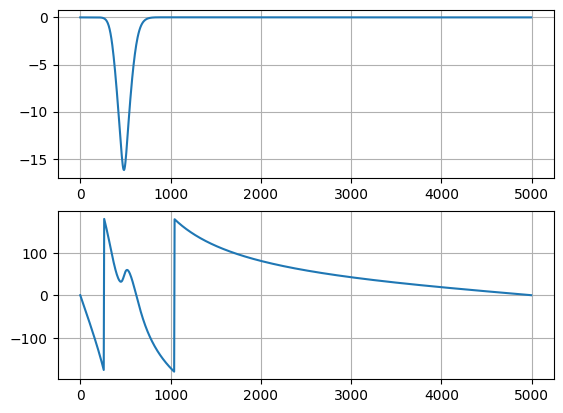

In [65]:
Hz_rejeita_faixa = get_Hz_filter(Hs_rejeita_faixa, fs)
plot_Hz(Hz_rejeita_faixa, fs)

### 5) Fazer uma função Python para implementar o filtro projetado. Esta função deve receber como argumento de entrada somente o sinal a ser filtrado e deve devolver somente o sinal filtrado e não deve conter comandos de construção do filtro. Aplicar esta função no sinal do exercício 4. Forneça o espectro do sinal filtrado que comprova o funcionamento da função de filtragem.

Sinal filtrado: [ 0.        +0.00000000e+00j  0.60410453+0.00000000e+00j
 -0.07726489-2.69764028e-15j ... -1.33798417-8.06854461e-07j
 -1.57801285-7.00732669e-07j -1.60209225-5.99874871e-07j]
sinal:  [ 0.          1.66141426  3.11893859 ... -4.19946065 -3.11893859
 -1.66141426]


c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


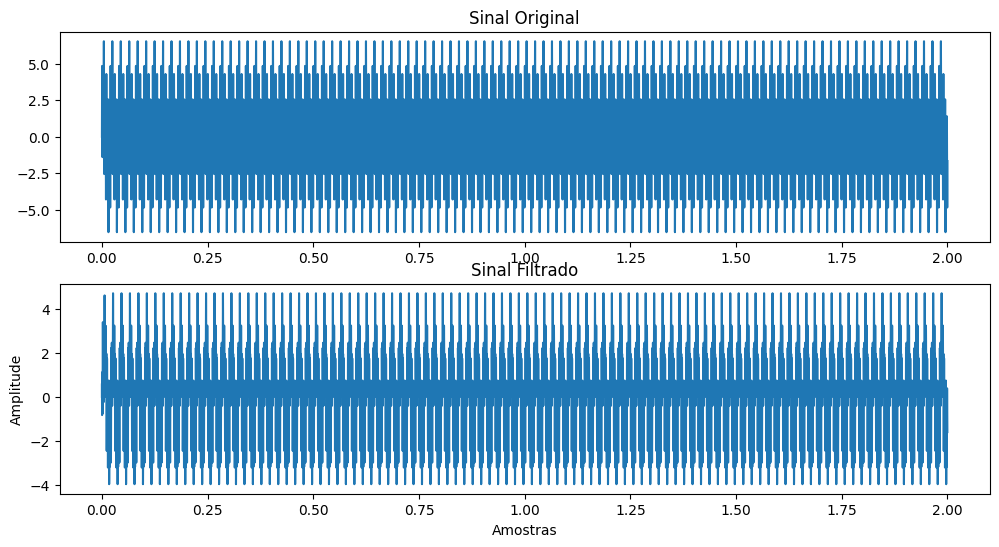

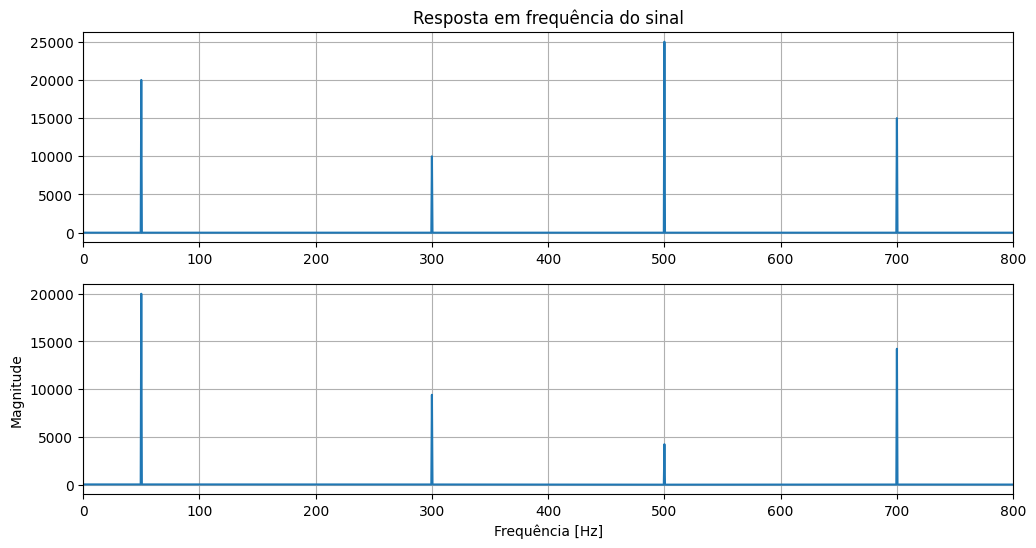

In [66]:
t = np.arange(0, 2, 1/fs)
yout = filtrar_sinal(Hz_rejeita_faixa, signal_data, t)


print('Sinal filtrado:', yout)
print('sinal: ', signal_data)

# Plot no domínio do tempo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal_data)
plt.title('Sinal Original')
plt.subplot(2, 1, 2)
plt.plot(t, yout)
plt.title('Sinal Filtrado')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')


# Resposta em frequência (FFT)
frequencia = np.fft.fftfreq(len(signal_data), 1/fs)
espectro = np.fft.fft(signal_data)

frequencia_filtr = np.fft.fftfreq(len(yout), 1/fs)
espectro_filtr = np.fft.fft(yout)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencia[:len(frequencia)//2], np.abs(espectro)[:len(frequencia)//2])
plt.title('Resposta em frequência do sinal')
plt.grid(True)
plt.xlim(0, 800)
plt.subplot(2, 1, 2)
plt.plot(frequencia_filtr[:len(frequencia_filtr)//2], np.abs(espectro_filtr)[:len(frequencia_filtr)//2])
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 800)
plt.show()